# Autoscout24.ch Price Monitor

The idea is to get an automated (eventually daily) price overview for a specific type of car. But also exploratory data analysis done to find some patterns or the 'best' valued car for money. 
As Autoscout24.ch does not offer a free API, we use web scraping to get the data we are interested in. 
Weak point in this approach is the possibility of changes in the HTML structure. This would require changes also in the Jupyter notebook.

(c) Manuel Kohler, Basel, Switzerland

In [43]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
import altair as alt
import datetime

# !{sys.executable} -m pip install numpy
# !pip install --upgrade pip --user

print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [125]:
baseurl = 'https://www.autoscout24.ch'
bmwi3_baseurl = baseurl + '/de/autos/bmw--i3'
# default is 20 cars per page, which would mean 20*10 cars
maxpages = 10

link_list = [] 

for i in range(1, maxpages):
    # fuel:16 = electro only, no REX
    # make:9 = BMW
    # model:1949 = i3    
    payload = {'fuel':16, 'make': '9', 'model': '1949', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}
    
    # Cayman S
#     payload = {'make': '62', 'model': '449', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}    
    
    # Tesla S
#     payload = {'fuel':16, 'make': '391', 'model': '1919', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}

    # VW e-Golf
#     payload = {'fuel':16, 'make': '82', 'model': '585', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}

    # VW Petrol Golf
#     payload = {'fuel':14, 'make': '82', 'model': '585', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}


    print('Loading page: ', i)    
    r = requests.get(bmwi3_baseurl, params=payload)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # Searching now for such tags:
    # <a class="base-nav-link " data-qa="details-link" href="/de/d/bmw-i3-kleinwagen-2017-occasion?vehid=6797569&amp;backurl=%2Fautos%2Fbmw--i \
    # 3%3Ffuel%3D16%26make%3D9%26model%3D1949%26sort%3Dprice_asc%26page%3D2%26vehtyp%3D10&amp;fuel=16&amp;make=9&amp;model=1949&amp;sort=price_asc&amp;page=2&amp;vehtyp=10">
    
    # Documentation about find_all using a name argument: https://www.crummy.com/software/BeautifulSoup/bs4/doc/#the-name-argument
    car_links = soup.find_all(attrs={"data-qa": "details-link"})
#     print(car_links)
    
    # if no more new cars found we can exit the for loop. 
    # maxpages is then bigger than the real number of cars
    if (len(car_links) == 0):
        print(f"No more cars found after {i-1} iterations")
        break
    for car_link in car_links:
        link_list.append(car_link['href'])
        
print('Found ' + str(len(link_list)) + ' cars')

Loading page:  1
Loading page:  2
Loading page:  3
Loading page:  4
Loading page:  5
Loading page:  6
Loading page:  7
Loading page:  8
Loading page:  9
No more cars found after 8 iterations
Found 148 cars


In [126]:
car_list = []

# data_fields = ["Inverkehrsetzung", "Fahrzeugart", "Aussenfarbe", "Kilometer", "Getriebeart", 
#                "Antriebsart", "Treibstoff", "Türen", "Sitze", "Innenfarbe", "Hubraum",
#                "Zylinder", "PS", "Leergewicht", "Verbrauch in l/100 km","CO2-Emission",
#                "Energieeffizienz", "Euro Norm", "Wagen-Nr.", "Ab MFK ", "Direkt-/Parallelimport",
#                "Garantie", "Neupreis", "Preis"]

for carIdx, carVal in enumerate(link_list):
    car = {}
        
    if (carIdx % 10 == 0) and (carIdx > 0):
        print(f"Downloaded {carIdx} cars")
    individual_car_request = requests.get(baseurl + carVal)
    soup = BeautifulSoup(individual_car_request.text, 'html.parser')
    
    # extract the individual vehical id given by autoscout, I assume that those are unique
    vehid = carVal.split("&")[0].split("=")[1]
    
    car['vehid'] = vehid
    car['carLink'] = '/'.join([baseurl, vehid])
    
    # The extraction of the price below is more elegant
    # <span class="mr-2 font-weight-bold h1">CHF 16'900.–</span>
    #raw_price = soup.find_all(class_="mr-2 font-weight-bold h1")
    #car['Preis'] = int("".join([s for s in raw_price[0].string if s.isdigit()]))
    
    title = soup.find("title").string.split(",")
    car['Name'] = title[0]
    car['Preis'] = int("".join([s for s in title[4] if s.isdigit()]))

    # Now we tackle this part of html which is ugly to parse as autoscout replaced names with some SVGs
    #     <section class="details-specifications">
    #         <h2 class="font-weight-bold mb-3">Fahrzeugdaten</h2><div class="row"><div class="col-12 col-sm-6 col-md-8"><div class="row"><div class="col-12 col-md-6 mb-3">
    #         <div class="key-value "><div class="mr-2"><span class="base-icon d-r key-value-key bold-primary "><svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 24 24"><path d="M9 [...]
    #         0 0 0 2 2h14c1.1 0 2-.9 2-2V6c0-1.1-.9-2-2-2zm0 16H5V9h14v11z"></path></svg></span></div><span class="raw-html key-value-value ">12.2016</span>
    
    details_specifications = soup.find_all("section", class_="details-specifications")
    
    for details_specification in details_specifications:
        detail_values = details_specification.find_all("span", class_="raw-html key-value-value")
        
        car['Inverkehrsetzung'] = detail_values[0].string
        car ['Kilometer'] = int(detail_values[1].string.split(" ")[0].replace("'",""))
        car ['PS'] = detail_values[2].string.split(" ")[0]
        car ['Treibstoff'] = detail_values[3].string
        car ['Getriebeart'] = detail_values[4].string
        car ['Antriebsart'] = detail_values[5].string        
    
    car_list.append(car)

print(f"Downloaded {carIdx+1} car details in total.")

Downloaded 10 cars
Downloaded 20 cars
Downloaded 30 cars
Downloaded 40 cars
Downloaded 50 cars
Downloaded 60 cars
Downloaded 70 cars
Downloaded 80 cars
Downloaded 90 cars
Downloaded 100 cars
Downloaded 110 cars
Downloaded 120 cars
Downloaded 130 cars
Downloaded 140 cars
Downloaded 148 car details in total.


In [127]:
car_df = pd.DataFrame(car_list, dtype=object).fillna('0')

# Thanks for this hint:
# https://stackoverflow.com/questions/42263946/how-to-create-a-table-with-clickable-hyperlink-in-pandas-jupyter-notebook
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">Link</a>'.format(val)

# Missing on the webpage, sort by the latest uploaded cars
# I assume that the vehid is similar to a DB sequence
car_df.sort_values(by=['vehid'], ascending=False).style.format({'carLink': make_clickable})

,Antriebsart,Getriebeart,Inverkehrsetzung,Kilometer,Name,PS,Preis,Treibstoff,carLink,vehid
0,Hinterradantrieb,Automatisiertes Schaltgetriebe,08.2014,84000,BMW i3 (60Ah),170,16900,Elektro,Link,6804590
91,Hinterradantrieb,Automatisiertes Schaltgetriebe,Neu,10,BMW i3s (120Ah),184,45990,Elektro,Link,6801980
92,Hinterradantrieb,Automatisiertes Schaltgetriebe,Neu,10,BMW i3s (120Ah),184,45990,Elektro,Link,6801903
28,Hinterradantrieb,Automatisiertes Schaltgetriebe,05.2017,6300,BMW i3 (94Ah),170,26800,Elektro,Link,6801896
119,Hinterradantrieb,Automatisiertes Schaltgetriebe,06.2019,2000,BMW i3s (120Ah),184,49999,Elektro,Link,6801680
4,Hinterradantrieb,Automatisiertes Schaltgetriebe,01.2014,44000,BMW i3 (60Ah),170,18800,Elektro,Link,6798877
29,Hinterradantrieb,Automatisiertes Schaltgetriebe,01.2017,12500,BMW i3 (94Ah),170,26800,Elektro,Link,6797569
23,Hinterradantrieb,Automatisiertes Schaltgetriebe,12.2016,11300,BMW i3 (94Ah),170,25490,Elektro,Link,6795083
24,Hinterradantrieb,Automatisiertes Schaltgetriebe,12.2016,9900,BMW i3 (94Ah),170,25990,Elektro,Link,6795082
105,Hinterradantrieb,Automatisiertes Schaltgetriebe,Neu,5,BMW i3s (120Ah),184,48500,Elektro,Link,6794503


In [128]:
# might be better to subgroup them

cars_120Ah = car_df[car_df['Name'].str.contains("120Ah")]
cars_94Ah = car_df[car_df['Name'].str.contains("94Ah")]
cars_60Ah = car_df[car_df['Name'].str.contains("60Ah")]

cars_60Ah

,Antriebsart,Getriebeart,Inverkehrsetzung,Kilometer,Name,PS,Preis,Treibstoff,carLink,vehid
0,Hinterradantrieb,Automatisiertes Schaltgetriebe,08.2014,84000,BMW i3 (60Ah),170,16900,Elektro,https://www.autoscout24.ch/6804590,6804590
1,Hinterradantrieb,Automatisiertes Schaltgetriebe,04.2014,40000,BMW i3 (60Ah),170,17600,Elektro,https://www.autoscout24.ch/6724998,6724998
2,Hinterradantrieb,Automatisiertes Schaltgetriebe,03.2014,42800,BMW i3 (60Ah),170,18500,Elektro,https://www.autoscout24.ch/6697466,6697466
3,Hinterradantrieb,Automatisiertes Schaltgetriebe,10.2014,23800,BMW i3 (60Ah),170,18500,Elektro,https://www.autoscout24.ch/6462217,6462217
4,Hinterradantrieb,Automatisiertes Schaltgetriebe,01.2014,44000,BMW i3 (60Ah),170,18800,Elektro,https://www.autoscout24.ch/6798877,6798877
5,Hinterradantrieb,Automatisiertes Schaltgetriebe,04.2015,58000,BMW i3 (60Ah),170,18800,Elektro,https://www.autoscout24.ch/6774809,6774809
6,Hinterradantrieb,Automatisiertes Schaltgetriebe,12.2013,41000,BMW i3 (60Ah),170,18900,Elektro,https://www.autoscout24.ch/6776801,6776801
7,Hinterradantrieb,Automatisiertes Schaltgetriebe,08.2014,61000,BMW i3 (60Ah),170,19500,Elektro,https://www.autoscout24.ch/6774812,6774812
8,Hinterradantrieb,Automatisiertes Schaltgetriebe,10.2014,51500,BMW i3 (60Ah),170,19900,Elektro,https://www.autoscout24.ch/6668286,6668286
9,Hinterradantrieb,Automatisiertes Schaltgetriebe,03.2015,38800,BMW i3 (60Ah),170,19900,Elektro,https://www.autoscout24.ch/6416806,6416806


In [129]:
now = datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S')
car_df.to_csv(f"./cars_{payload['make']}_{payload['model']}_{now}.csv", encoding='utf-8')
car_df.to_excel(f"./cars_{payload['make']}_{payload['model']}_{now}.xlsx", sheet_name='autoscout24.ch')

In [130]:
# import matplotlib.pyplot as plt
# new_df.plot(kind='scatter',x='cleanPrice',y='cleanKilometer',color='red')
# plt.show()

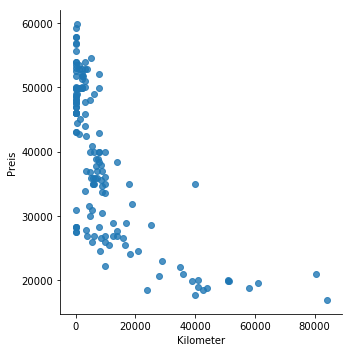

In [131]:
sns.lmplot('Kilometer', 'Preis', data=car_df, fit_reg=False)

In [132]:
import numpy as np

# Let's try a naive way of finding the car with the best value (obvislously a soft target)
# which in this simple approach means all the dots which have a short distance to the origin. No features
# are considered in this case.
# We can easily calculate this using good old Pythagoras

a = car_df.copy()
a['dist_to_origin'] = np.sqrt((car_df['Kilometer'])^2 + (car_df['Preis'])^2)
a.sort_values(by=['dist_to_origin'])

,Antriebsart,Getriebeart,Inverkehrsetzung,Kilometer,Name,PS,Preis,Treibstoff,carLink,vehid,dist_to_origin
41,Hinterradantrieb,Automatisiertes Schaltgetriebe,09.2017,25400,BMW i3 (94Ah) Black Edition,170,28500,Elektro,https://www.autoscout24.ch/6785254,6785254,56.391489
54,Hinterradantrieb,Automatisiertes Schaltgetriebe,12.2016,39900,BMW i3 (94Ah),170,34900,Elektro,https://www.autoscout24.ch/6754446,6754446,70.710678
3,Hinterradantrieb,Automatisiertes Schaltgetriebe,10.2014,23800,BMW i3 (60Ah),170,18500,Elektro,https://www.autoscout24.ch/6462217,6462217,72.856022
19,Hinterradantrieb,Automatisiertes Schaltgetriebe,06.2015,18250,BMW i3 (60Ah),170,23990,Elektro,https://www.autoscout24.ch/6406003,6406003,83.042158
22,Hinterradantrieb,Automatisiertes Schaltgetriebe,10.2015,16490,BMW i3 (60Ah),170,25400,Elektro,https://www.autoscout24.ch/6580088,6580088,95.089432
18,Hinterradantrieb,Automatisiertes Schaltgetriebe,05.2015,28900,BMW i3 (60Ah),170,22997,Elektro,https://www.autoscout24.ch/6058137,6058137,102.688850
21,Hinterradantrieb,Automatisiertes Schaltgetriebe,03.2015,21034,BMW i3 (60Ah),170,24600,Elektro,https://www.autoscout24.ch/6646871,6646871,113.357840
42,Hinterradantrieb,Automatisiertes Schaltgetriebe,04.2017,17000,BMW i3 (94Ah),170,28900,Elektro,https://www.autoscout24.ch/6590680,6590680,113.754121
49,Hinterradantrieb,Automatisiertes Schaltgetriebe,04.2018,18800,BMW i3 (94Ah),170,31900,Elektro,https://www.autoscout24.ch/6653629,6653629,117.490425
13,Hinterradantrieb,Automatisiertes Schaltgetriebe,04.2015,27870,BMW i3 (60Ah),170,20700,Elektro,https://www.autoscout24.ch/6708706,6708706,123.943536
